## Data Loading and Parameters

In [24]:
"""
Data loading and preprocessing for quantile regression tree experiments.

This script loads the energy efficiency dataset and prepares it for model training.
"""

import pandas as pd
from sklearn.model_selection import train_test_split

# Load the energy efficiency dataset
path = r"data/energy_efficiency_data.csv"
df = pd.read_csv(path)

# Define feature columns and target variable
feature_cols = df.columns[:8].tolist()  # First 8 columns are features
label_col = "Y1"  # Target variable: Heating Load

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    df[feature_cols], df[label_col],
    test_size=0.2, random_state=42
)

# Prepare data for the tree algorithm (legacy format)
train_df = pd.concat([X_train, y_train], axis=1)
train_dataset = train_df.values.tolist()
feature_names = feature_cols.copy()

# Model hyperparameters
max_depth = 5  # Maximum tree depth
min_size = 1   # Minimum samples per leaf node

## Example Usage and Tree Structure Visualization

In [25]:
"""
Example usage of the QuantileRegressionTree class.

This example demonstrates how to create, train, and inspect a quantile regression tree.
"""
from models.quantile_regression_tree import QuantileRegressionTree

# 1. Create QRT instance with R² splitting criterion
qrt = QuantileRegressionTree(split_criterion='r2', max_depth=3, min_size=1)

# 2. Train the model on 50th percentile (median)
qrt.fit(X_train, y_train, quantile=0.5, feature_names=feature_names)

# 3. Get tree structure as DataFrame for inspection
tree_df = qrt.get_tree_structure()

print("Tree Structure:")
print(tree_df)

Tree Structure:
   Node ID  Parent ID Feature Name Condition  Numeric Threshold  Prediction
0        0        NaN         None      None                NaN         NaN
1        1        0.0           X1         <              0.750         NaN
2        2        0.0           X1        >=              0.750         NaN
3        3        1.0           X7         <              0.175      11.215
4        4        1.0           X7        >=              0.175      14.460
5        5        2.0           X1         <              0.805      37.795
6        6        2.0           X1        >=              0.805      28.660


## Visualization and Model Comparison

In [26]:
"""
Model definitions for interval prediction comparison.

This section defines the models used for comparing different quantile regression approaches:
- QR-Tree with R² splitting criterion  
- QR-Tree with quantile loss splitting criterion
- Sklearn's linear quantile regression
"""

from collections import OrderedDict
from sklearn.linear_model import QuantileRegressor
from models.quantile_regression_tree import predict_quantile_interval

# Interval prediction model definitions (using concise lambda expressions)
models_interval = OrderedDict([
    ('QR-Tree(R²)', lambda lq, uq: (y_test, *predict_quantile_interval(
        X_train, y_train, X_test, lq, uq, 'r2', max_depth, min_size, feature_names))),
    
    ('QR-Tree(loss)', lambda lq, uq: (y_test, *predict_quantile_interval(
        X_train, y_train, X_test, lq, uq, 'loss', max_depth, min_size, feature_names))),
    
    ('QR (sklearn)', lambda lq, uq: (
        y_test,
        QuantileRegressor(quantile=lq, alpha=0.0, solver="highs").fit(X_train, y_train).predict(X_test),
        QuantileRegressor(quantile=uq, alpha=0.0, solver="highs").fit(X_train, y_train).predict(X_test)
    )),
])

print("✅ Concise model definitions completed!")

✅ Concise model definitions completed!


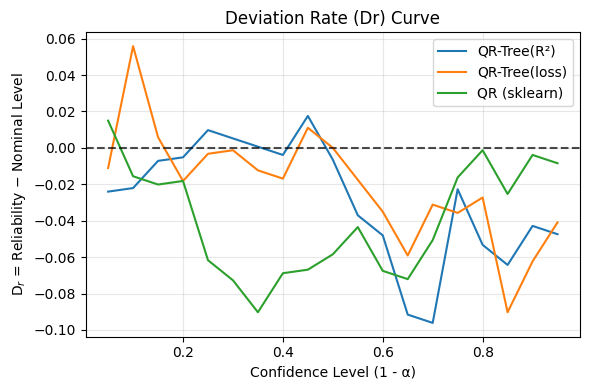

In [27]:
"""
Dr (Deviation Rate) Curve Visualization.

This plot shows the difference between observed and expected coverage rates
across different confidence levels for each quantile regression method.
"""

import numpy as np
import matplotlib.pyplot as plt
from utils.performance_evaluation import *

# 1. Define confidence levels
levels = np.linspace(0.05, 0.95, 19)

# 2. Collect Dr values for each model
dr_vals = {name: [] for name in models_interval}
for lvl in levels:
    alpha = 1 - lvl  # Miscoverage rate
    lq, uq = alpha / 2, 1 - alpha / 2  # Lower and upper quantiles

    for name, fn in models_interval.items():
        y, low, up = fn(lq, uq)
        rs = reliability_score(y, low, up)  # Observed coverage
        dr_vals[name].append(dr_metric(rs, alpha))  # Deviation from nominal

# 3. Create the plot
plt.figure(figsize=(6, 4))
for name, vals in dr_vals.items():
    plt.plot(levels, vals, label=name)
plt.axhline(0, color='k', linestyle='--', alpha=0.7)  # Perfect calibration line
plt.xlabel('Confidence Level (1 - α)')
plt.ylabel('D$_r$ = Reliability − Nominal Level')
plt.title('Deviation Rate (Dr) Curve')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


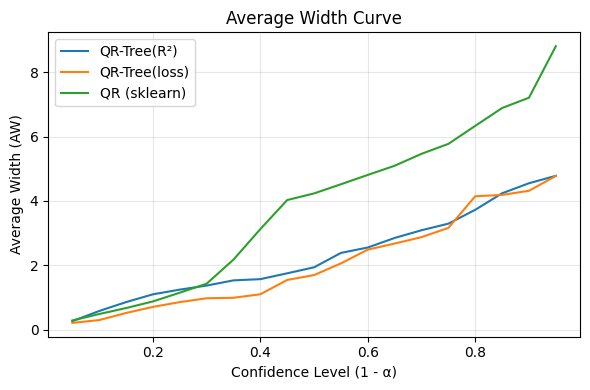

In [28]:
"""
Average Width (AW) Curve Visualization.

This plot shows the average width of prediction intervals across different
confidence levels for each quantile regression method. Lower values indicate
more precise predictions.
"""

import numpy as np
import matplotlib.pyplot as plt
from utils.performance_evaluation import *

levels = np.linspace(0.05, 0.95, 19)

# Collect average width values for each model
aw_vals = {name: [] for name in models_interval}
for lvl in levels:
    alpha = 1 - lvl  # Miscoverage rate
    lq, uq = alpha / 2, 1 - alpha / 2  # Lower and upper quantiles

    for name, fn in models_interval.items():
        y, low, up = fn(lq, uq)
        aw_vals[name].append(aw_metric(low, up))  # Average interval width

# Create the plot
plt.figure(figsize=(6, 4))
for name, vals in aw_vals.items():
    plt.plot(levels, vals, label=name)
plt.xlabel('Confidence Level (1 - α)')
plt.ylabel('Average Width (AW)')
plt.title('Average Width Curve')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
"""
Average Prediction Interval Score (APIS) Curve Visualization.

This plot shows the APIS metric across different confidence levels for each
quantile regression method. APIS combines interval width with coverage penalties,
where lower values indicate better overall performance.
"""

import numpy as np
import matplotlib.pyplot as plt
from utils.performance_evaluation import *

levels = np.linspace(0.05, 0.95, 19)

# Collect APIS values for each model
apis_vals = {name: [] for name in models_interval}
for lvl in levels:
    alpha = 1 - lvl  # Miscoverage rate
    lq, uq = alpha / 2, 1 - alpha / 2  # Lower and upper quantiles

    for name, fn in models_interval.items():
        y, low, up = fn(lq, uq)
        apis_vals[name].append(apis_metric(y, low, up, alpha))  # APIS score

# Create the plot
plt.figure(figsize=(6, 4))
for name, vals in apis_vals.items():
    plt.plot(levels, vals, label=name)
plt.xlabel('Confidence Level (1 - α)')
plt.ylabel('Average Prediction Interval Score (APIS)')
plt.title('APIS Curve')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
"""
Model definitions for single-point quantile prediction comparison.

This section defines models for comparing quantile prediction performance
at specific quantile levels across different methods.
"""

from utils.performance_evaluation import *

# Concise single-point prediction model definitions (using lambda expressions)
models = {
    'QR-Tree(R²)': lambda q: (y_test, QuantileRegressionTree('r2', max_depth, min_size)
                              .fit(X_train, y_train, q, feature_names).predict(X_test)),
    
    'QR-Tree(loss)': lambda q: (y_test, QuantileRegressionTree('loss', max_depth, min_size)
                                .fit(X_train, y_train, q, feature_names).predict(X_test)),
    
    'QR (sklearn)': lambda q: (y_test, QuantileRegressor(quantile=q, alpha=0.0, solver="highs")
                               .fit(X_train, y_train).predict(X_test))
}

print("✅ Concise single-point prediction model definitions completed!")

In [ ]:
"""
Average Quantile Score (AQS) Curve Visualization.

This plot shows the average quantile score (pinball loss) across different
quantile levels for each method. Lower values indicate better quantile
prediction accuracy.
"""

import numpy as np
import matplotlib.pyplot as plt
from utils.performance_evaluation import *

qs = np.linspace(0.05, 0.95, 19)

# AQS curve: Calculate average quantile loss for each model and quantile level
aqs_results = {name: [] for name in models}
for q in qs:
    for name, fn in models.items():
        y, pred = fn(q)
        aqs_results[name].append(pinball_loss(y, pred, q))  # Pinball loss

# Plot AQS curves
plt.figure(figsize=(6, 4))
for name, vals in aqs_results.items():
    plt.plot(qs, vals, label=name)
plt.xlabel('Quantile Level (τ)')
plt.ylabel('Average Quantile Score (Pinball Loss)')
plt.title('Average Quantile Score Curve Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
"""
Murphy Diagram Visualization.

Murphy diagrams show elementary scores for different threshold values at specific
quantile levels. They provide detailed insight into the quality of quantile
predictions across the entire range of possible values.
"""

import numpy as np
import matplotlib.pyplot as plt
from utils.performance_evaluation import *

# Murphy diagram: Plot elementary scores for selected quantile levels
qs = np.linspace(0.1, 0.9, 9)  # Quantile levels to analyze
thetas = np.linspace(y_test.min(), y_test.max(), 500)  # Threshold range

for q in qs:
    plt.figure(figsize=(6, 4))
    
    for name, fn in models.items():
        y_true, y_pred = fn(q)
        abs_err = np.abs(y_true - y_pred)
        scores = []

        for theta in thetas:
            S = np.zeros_like(y_true, dtype=float)

            # Case 1: y_true ≤ θ < y_pred → S = 1 - τ (underestimation penalty)
            mask1 = (y_true <= theta) & (theta < y_pred)
            S[mask1] = 1 - q

            # Case 2: y_pred ≤ θ < y_true → S = τ (overestimation penalty)
            mask2 = (y_pred <= theta) & (theta < y_true)
            S[mask2] = q

            scores.append(np.mean(S * abs_err))  # Weighted elementary score

        plt.plot(thetas, scores, label=name)

    plt.xlabel('Threshold θ')
    plt.ylabel('Elementary Score')
    plt.title(f'Murphy Diagram (τ={q:.1f})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()